In [1]:
from math import log, sqrt, pi, exp, floor
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from datetime import datetime, date
import numpy as np
from yahoo_fin import options
from yahoo_fin import stock_info as si

In [2]:
### Black-Scholes Pricers ###
def d1(S, K, t, r, q, vola):
    return(log(S/K)+(r-q+vola**2/2.)*t)/(vola*sqrt(t))

def d2(S, K, t, r, q, vola):
    return d1(S, K, t, r, q, vola)-vola*sqrt(t)

def bs_call(S, K, t, r, q, vola):
    return S*exp(-q*t)*norm.cdf(d1(S, K, t, r, q, vola))-K*exp(-r*t)*norm.cdf(d2(S, K, t, r, q, vola))

def bs_put(S, K, t, r, q, vola):
    return K*exp(-r*t)-S*exp(-q*t)+bs_call(S, K, t ,r, q, vola)

In [3]:
### Black-Scholes implied volatility calculation formulas ###

def implied_volatility_bs_call(S, K, t, r, q, call_market_price, a=-2.0, b=2.0, xtol=1e-6):
    _S, _K, _t, _r, _q, _call_market_price = S, K, t, r, q, call_market_price
    
    # define a nested function with only volatility as input
    def call_iv_objective_func(vola):
        return _call_market_price - bs_call(_S, _K, _t, _r, _q, vola)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(call_iv_objective_func, a=a, b=b, xtol=xtol)
        
        # if the results are too small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    except ValueError:
        return np.nan
    
def implied_volatility_bs_put(S, K, t, r, q, put_market_price, a=-2.0, b=2.0, xtol=1e-6):
    _S, _K, _t, _r, _q, _put_market_price = S, K, t, r, q, put_market_price
    
    # define a nested function with only volatility as input
    def put_iv_objective_func(vola):
        return _put_market_price - bs_put(_S, _K, _t, _r, _q, vola)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(put_iv_objective_func, a=a, b=b, xtol=xtol)
        
        # if the results are too small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    except ValueError:
        return np.nan

#Test functions
S = 45.0
K = 45.0
t = 164.0/365.0
r = 0.02
q = 0.014
vola = 0.25

call_price = bs_call(S, K, t, r, q, vola)
put_price = bs_put(S, K, t, r, q, vola)
print(call_price)
print(put_price)
print('Make sure that '+ str(implied_volatility_bs_call(S, K, t, r, q, call_price)) + ' is close to 0.25')
print('Make sure that '+ str(implied_volatility_bs_put(S, K, t, r, q, put_price)) + ' is close to 0.25')

3.042619508627517
2.922227521338826
Make sure that 0.24999985507818948 is close to 0.25
Make sure that 0.24999985507818948 is close to 0.25


In [4]:
### European option pricers (Binomial Tree) ###
def binomial_european_call_pricer (S, K, t, t_q, r, q, vola, N):
    u = exp(vola*sqrt(t/N))
    d = exp(-vola*sqrt(t/N))
    R = exp(r*t/N)
    p = (R-d)/(u-d)

    #Create vector where all indices past the ex-div date contain the dividend as % of spot
    dividend = np.zeros(N + 1)

    if t_q <= t and t_q != 0:
        dividend_index = int(floor(t_q/t * N))

        for i in range(N + 1):
            if i >= dividend_index:
                dividend[i] = q


    #Build price tree deducting the dividend
    stock = np.zeros([N + 1, N + 1])
    for i in range(N + 1):
        for j in range(i + 1):
            stock[j, i] = S * (u ** (i - j)) * (d ** j) * (1 - dividend[i])

    # Generate option prices recursively
    option = np.zeros([N + 1, N + 1])
    option[:, N] = np.maximum(np.zeros(N + 1), stock[:, N] - K)

    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option[j, i] = (
                 (p * option[j, i + 1] + (1 - p) * option[j + 1, i + 1]) / R
            )

    return option[0, 0]

def binomial_european_put_pricer (S, K, t, t_q, r, q, vola, N):
    u = exp(vola*sqrt(t/N))
    d = exp(-vola*sqrt(t/N))
    R = exp(r*t/N)
    p = (R-d)/(u-d)

    #Create vector where all indices past the ex-div date contain the dividend as % of spot
    dividend = np.zeros(N + 1)

    if t_q <= t and t_q != 0:
        dividend_index = int(floor(t_q/t * N))

        for i in range(N + 1):
            if i >= dividend_index:
                dividend[i] = q


    #Build price tree deducting the dividend
    stock = np.zeros([N + 1, N + 1])
    for i in range(N + 1):
        for j in range(i + 1):
            stock[j, i] = S * (u ** (i - j)) * (d ** j) * (1 - dividend[i])

    # Generate option prices recursively
    option = np.zeros([N + 1, N + 1])
    option[:, N] = np.maximum(np.zeros(N + 1), (K - stock[:, N]))

    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option[j, i] = (
                 (p * option[j, i + 1] + (1 - p) * option[j + 1, i + 1]) / R
            )

    return option[0, 0]

print(binomial_european_call_pricer(S=45, K=45, vola=0.25, t=164.0/365.0, t_q=163.0/365.0, r=0.02, q=0.014, N=200))
print(binomial_european_put_pricer(S=45, K=45, vola=0.25, t=164.0/365.0, t_q=163.0/365.0, r=0.02, q=0.014, N=200))

2.8614912121546094
3.088919176420905


In [5]:
### Binomial european implied volatility calculation formulas ###

def iv_binomial_european_call(S, K, t, t_q, r, q, N, call_market_price, a=0.01, b=2.0, xtol=1e-6):
    _S, _K, _t, _t_q, _r, _q, _N, _call_market_price = S, K, t, t_q, r, q, N, call_market_price
    
    # define a nested function with only volatility as input
    def call_iv_objective_func(vola):
        return _call_market_price - binomial_european_call_pricer(_S, _K, _t, _t_q, _r, _q, vola, _N)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(call_iv_objective_func, a=a, b=b, xtol=xtol)

        # if the results are too small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    except ValueError:
        print("call error")
        return np.nan
    
def iv_binomial_european_put(S, K, t, t_q, r, q, N, put_market_price, a=0.01, b=2.0, xtol=1e-6):
    _S, _K, _t, _t_q, _r, _q, _N, _put_market_price = S, K, t, t_q, r, q, N, put_market_price
    
    # define a nested function with only volatility as input
    def put_iv_objective_func(vola):
        return _put_market_price - binomial_european_put_pricer(_S, _K, _t, _t_q, _r, _q, vola, _N)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(put_iv_objective_func, a=a, b=b, xtol=xtol)

        # if the results are too small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    except ValueError:
        print("put error")
        return np.nan

#Test functions
S = 45.0
K = 45.0
t = 20/365
t_q = 20/365
r = 0.009
q = 0.0139
vola = 0.25
N = 200

call_price = binomial_european_call_pricer(S, K, t, t_q, r, q, vola, N)
put_price = binomial_european_put_pricer(S, K, t, t_q, r, q, vola, N)
print(call_price)
print(put_price)
print('Make sure that '+ str(iv_binomial_european_call(S, K, t, t_q, r, q, N, call_price)) + ' is close to 0.25')
print('Make sure that '+ str(iv_binomial_european_put(S, K, t, t_q, r, q, N, put_price)) + ' is close to 0.25')

0.7697354240265666
1.3730491142518082
Make sure that 0.25000001151192314 is close to 0.25
Make sure that 0.25000001151192275 is close to 0.25


In [6]:
### American option pricers (Binomial Tree) ###
def binomial_american_call_pricer (S, K, t, t_q, r, q, vola, N):
    u = exp(vola*sqrt(t/N))
    d = exp(-vola*sqrt(t/N))
    R = exp(r*t/N)
    p = (R-d)/(u-d)

    #Create vector where all indices past the ex-div date contain the dividend as % of spot
    dividend = np.zeros(N + 1)

    if t_q <= t and t_q != 0:
        dividend_index = int(floor(t_q/t * N))

        for i in range(N + 1):
            if i >= dividend_index:
                dividend[i] = q


    #Build price tree deducting the dividend
    stock = np.zeros([N + 1, N + 1])
    for i in range(N + 1):
        for j in range(i + 1):
            stock[j, i] = S * (u ** (i - j)) * (d ** j) * (1 - dividend[i])

    # Generate option prices recursively
    option = np.zeros([N + 1, N + 1])
    option[:, N] = np.maximum(np.zeros(N + 1), stock[:, N] - K)

    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option[j, i] = (
                 np.maximum(stock[j, i] - K, (p * option[j, i + 1] + (1 - p) * option[j + 1, i + 1]) / R)
            )

    return option[0, 0]

def binomial_american_put_pricer (S, K, t, t_q, r, q, vola, N):
    u = exp(vola*sqrt(t/N))
    d = exp(-vola*sqrt(t/N))
    R = exp(r*t/N)
    p = (R-d)/(u-d)

    #Create vector where all indices past the ex-div date contain the dividend as % of spot
    dividend = np.zeros(N + 1)

    if t_q <= t and t_q != 0:
        dividend_index = int(floor(t_q/t * N))

        for i in range(N + 1):
            if i >= dividend_index:
                dividend[i] = q


    #Build price tree deducting the dividend
    stock = np.zeros([N + 1, N + 1])
    for i in range(N + 1):
        for j in range(i + 1):
            stock[j, i] = S * (u ** (i - j)) * (d ** j) * (1 - dividend[i])

    # Generate option prices recursively
    option = np.zeros([N + 1, N + 1])
    option[:, N] = np.maximum(np.zeros(N + 1), (K - stock[:, N]))

    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option[j, i] = (
                 np.maximum(K - stock[j, i], (p * option[j, i + 1] + (1 - p) * option[j + 1, i + 1]) / R)
            )

    return option[0, 0]

print(binomial_american_call_pricer(S=100, K=100, vola=0.15, t=1., t_q=1., r=0.1, q=0.0139, N=10))
print(binomial_american_put_pricer(S=100, K=100, vola=0.15, t=1., t_q=1., r=0.1, q=0, N=10))


10.87384463741694
3.07621086348687


In [7]:
### Binomial american implied volatility calculation formulas ###

def iv_binomial_american_call(S, K, t, t_q, r, q, N, call_market_price, a=0.01, b=2.0, xtol=1e-6):
    _S, _K, _t, _t_q, _r, _q, _N, _call_market_price = S, K, t, t_q, r, q, N, call_market_price
    
    # define a nested function with only volatility as input
    def call_iv_objective_func(vola):
        return _call_market_price - binomial_american_call_pricer(_S, _K, _t, _t_q, _r, _q, vola, _N)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(call_iv_objective_func, a=a, b=b, xtol=xtol)

        # if the results are too small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    except ValueError:
        return np.nan
    
def iv_binomial_american_put(S, K, t, t_q, r, q, N, put_market_price, a=0.01, b=2.0, xtol=1e-6):
    _S, _K, _t, _t_q, _r, _q, _N, _put_market_price = S, K, t, t_q, r, q, N, put_market_price
    
    # define a nested function with only volatility as input
    def put_iv_objective_func(vola):
        return _put_market_price - binomial_american_put_pricer(_S, _K, _t, _t_q, _r, _q, vola, _N)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(put_iv_objective_func, a=a, b=b, xtol=xtol)

        # if the results are too small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    except ValueError:
        return np.nan

#Test functions
S = 45.0
K = 45.0
t = 20/365
t_q = 20/365
r = 0.009
q = 0.0139
vola = 0.25
N = 200

call_price = binomial_american_call_pricer(S, K, t, t_q, r, q, vola, N)
put_price = binomial_american_put_pricer(S, K, t, t_q, r, q, vola, N)
print(call_price)
print(put_price)
print('Make sure that '+ str(iv_binomial_american_call(S, K, t, t_q, r, q, N, call_price)) + ' is close to 0.25')
print('Make sure that '+ str(iv_binomial_american_put(S, K, t, t_q, r, q, N, put_price)) + ' is close to 0.25')

1.0599400180692105
1.3730491142518082
Make sure that 0.25000000000342965 is close to 0.25
Make sure that 0.25000001151192275 is close to 0.25


In [8]:
### Market data fetch ###

ticker = "spy"
options_series = datetime(2021, 9, 17)
chain = options.get_options_chain(ticker, options_series)
call_chain = chain["calls"]
put_chain = chain["puts"]
options.get_expiration_dates(ticker);
S = si.get_live_price("spy")

In [9]:
### Calculate time to expiration ###
expiration_date = datetime(2021, 9, 17, 16, 0, 0)
ex_dividend_date = datetime(2021, 9, 17)
minutes_in_a_year=365*24*60
t = floor((expiration_date - datetime.now()).total_seconds() / 60.) / minutes_in_a_year
t_q = floor((ex_dividend_date - datetime.now()).total_seconds() / 60 )/ minutes_in_a_year

In [10]:
pd.set_option('display.max_rows', 500) #Show n Dataframe rows
print(call_chain)
print(put_chain)

          Contract Name         Last Trade Date  Strike  Last Price     Bid  \
0    SPY210917C00115000   2021-08-24 6:32PM EDT   115.0      274.62  337.23   
1    SPY210917C00120000   2021-08-24 6:32PM EDT   120.0      295.71  332.22   
2    SPY210917C00130000   2021-08-24 6:32PM EDT   130.0      290.97  322.20   
3    SPY210917C00135000   2021-08-24 6:32PM EDT   135.0      285.33  317.21   
4    SPY210917C00140000  2021-08-18 10:45AM EDT   140.0      303.79  312.18   
5    SPY210917C00145000   2021-08-24 6:32PM EDT   145.0      275.56  307.24   
6    SPY210917C00150000   2021-08-24 6:32PM EDT   150.0      184.50  302.23   
7    SPY210917C00155000   2021-08-24 6:32PM EDT   155.0      176.38  297.25   
8    SPY210917C00170000   2021-08-24 6:32PM EDT   170.0      202.09  282.19   
9    SPY210917C00175000   2021-08-24 6:32PM EDT   175.0      247.05  277.22   
10   SPY210917C00180000   2021-08-24 6:32PM EDT   180.0      212.73  272.22   
11   SPY210917C00185000   2021-08-24 6:32PM EDT   18

In [11]:
### Organize the data ###
call_chain["Mid Price"] = (call_chain["Ask"] - call_chain["Bid"])/2. + call_chain["Bid"]
put_chain["Mid Price"] = (put_chain["Ask"] - put_chain["Bid"])/2. + put_chain["Bid"]

data = {"Strike" : call_chain["Strike"],
        "CallPrice" : call_chain["Mid Price"]}
data_chain = pd.DataFrame(data)

#Combine call and put prices by strike
for i, row in call_chain.iterrows():
    data_chain.loc[i, 'PutPrice'] = next(iter(put_chain.loc[put_chain['Strike'] == row['Strike']]['Mid Price']), np.nan)
    
#Clean up data
for i, row in data_chain.iterrows():
    if data_chain.loc[i, 'CallPrice'] < 0.05 or data_chain.loc[i, 'PutPrice'] < 0.05:
        data_chain.drop(index=i, inplace=True)
data_chain.dropna(inplace=True)
data_chain.reset_index(drop=True, inplace=True)
print(data_chain)

     Strike  CallPrice  PutPrice
0     328.0    124.520     0.055
1     329.0    123.615     0.055
2     330.0    122.665     0.055
3     331.0    121.860     0.055
4     332.0    120.830     0.055
5     333.0    119.555     0.055
6     334.0    118.535     0.055
7     335.0    117.595     0.065
8     336.0    116.565     0.065
9     337.0    115.655     0.065
10    338.0    114.690     0.065
11    339.0    113.580     0.065
12    340.0    112.520     0.065
13    341.0    111.695     0.065
14    342.0    110.625     0.075
15    343.0    109.555     0.075
16    344.0    108.855     0.075
17    345.0    107.710     0.075
18    346.0    106.740     0.075
19    347.0    105.695     0.085
20    348.0    104.600     0.085
21    349.0    103.530     0.085
22    350.0    102.610     0.085
23    351.0    101.625     0.085
24    352.0    100.715     0.095
25    353.0     99.615     0.095
26    354.0     98.580     0.095
27    355.0     97.670     0.095
28    356.0     96.815     0.105
29    357.

In [19]:
### Calibrate r and q so that ATM vols are the same ###
q = 0.0122/4
r = -0.006

#Find price where call and put prices are the closest
data_chain["PriceDelta"] = abs(data_chain["CallPrice"] - data_chain["PutPrice"])
minDiff = min(data_chain["PriceDelta"])
atm_strike = next(iter(data_chain.loc[data_chain["PriceDelta"] == minDiff]["Strike"]), np.nan)
atm_call_price = next(iter(data_chain.loc[data_chain["Strike"] == atm_strike]["CallPrice"]), np.nan)
atm_put_price = next(iter(data_chain.loc[data_chain["Strike"] == atm_strike]["PutPrice"]), np.nan)
print(atm_strike, atm_call_price, atm_put_price)

#Calculate ATM vols
iv_call = iv_binomial_american_call(S, atm_strike, t, t_q, r, q, 250, atm_call_price)
iv_put = iv_binomial_american_put(S, atm_strike, t, t_q, r, q, 250, atm_put_price)
print(iv_call, iv_put)

452.0 4.255 4.4
0.0992940651578303 0.09949080371926282


In [20]:
#Build volatility smile
data = {"Strike" : data_chain["Strike"],
        "ImpliedVol" : 0 }
vol_smile = pd.DataFrame(data)
for i, row in data_chain.iterrows():
    if row["Strike"] <= atm_strike:
        vol_smile.loc[i, 'ImpliedVol'] = iv_binomial_american_put(S, row["Strike"], t, t_q, r, q, 250, row["PutPrice"])
    else:
        vol_smile.loc[i, 'ImpliedVol'] = iv_binomial_american_call(S, row["Strike"], t, t_q, r, q, 250, row["CallPrice"])
    print(str(i) + "..", end="")
print("")
print("Done")

0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99..100..101..102..103..104..105..106..107..108..109..110..111..112..113..114..115..116..117..118..119..120..121..122..123..124..125..126..127..128..129..130..131..132..133..134..135..136..137..138..139..140..141..142..143..144..145..
Done


In [21]:
print(vol_smile)

     Strike  ImpliedVol
0     328.0    0.538512
1     329.0    0.533769
2     330.0    0.529018
3     331.0    0.524282
4     332.0    0.519561
5     333.0    0.514853
6     334.0    0.510160
7     335.0    0.513887
8     336.0    0.509208
9     337.0    0.504544
10    338.0    0.499893
11    339.0    0.495257
12    340.0    0.490634
13    341.0    0.486024
14    342.0    0.489746
15    343.0    0.485150
16    344.0    0.480569
17    345.0    0.476000
18    346.0    0.471292
19    347.0    0.472571
20    348.0    0.467876
21    349.0    0.463195
22    350.0    0.458527
23    351.0    0.453873
24    352.0    0.455165
25    353.0    0.450529
26    354.0    0.445905
27    355.0    0.441294
28    356.0    0.442584
29    357.0    0.437822
30    358.0    0.433074
31    359.0    0.428339
32    360.0    0.427936
33    361.0    0.423221
34    362.0    0.418519
35    363.0    0.413830
36    364.0    0.413447
37    365.0    0.408777
38    366.0    0.404121
39    367.0    0.403752
40    368.0    0

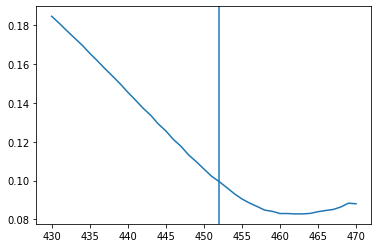

In [24]:
### Plot volatility smile ###
x_min = 430
x_max = 470
plot_data = vol_smile[(vol_smile["Strike"] >= x_min) & (vol_smile["Strike"] <= x_max)]
plt.plot(plot_data["Strike"], plot_data["ImpliedVol"])
plt.autoscale(enable=True, axis='y')
plt.axvline(x=atm_strike)
plt.show()